# Matching detections with SN Truth Catalog

## Summary
* Loading the data
* Defining convenient functions to unfold LightCurves
* Initialize tables and matching distance tolerance
* Producing the actual matching
* Producing the plots

In [1]:
import os
import sqlite3

In [2]:
os.environ['SCRATCH']='/global/cscratch1/sd/bos0109'
SCRATCH = %env SCRATCH

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
%matplotlib inline

In [6]:
from glob import glob

In [7]:
from astropy import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

### Loading the data
 We are loading the data from a set of files already produced and stored.
 The files contain the truth catalog for SN Ia and their parameters, as well
 a HDF5 storage container with the `diaSrc` catalogs stacked as a single table.

In [8]:
truth_lightc = pd.read_csv('../lightcurves/lightcurves_cat_rect_58.0_56.0_-31.0_-32.0.csv')
sntab = pd.read_csv('../catalogs+tables/supernovae_cat_rect_58.0_56.0_-31.0_-32.0.csv')
#truth_lightc = pd.read_csv('./lightcurves/lightcurves_cat_rect_58_56_-31_-32.csv')
#sntab = pd.read_csv('./catalogs+tables/supernovae_cat_rect_58_56_-31_-32.csv')

In [9]:
#diaSrc_store = pd.HDFStore('/global/cscratch1/sd/bos0109/diaSrc_forced_fulltables_v4.h5')
diaSrc_store = pd.HDFStore(f'{SCRATCH}/results/diaSrc_secrun_fulltables_v4.h5')
diaSrc_store.open()
metacols = ['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector']

### Defining convenient functions 

* Dealing with the truth catalog table and the SN parameters table is best achieved if encapsulated as single functions

In [10]:
def get_truth_LC(truth_tab, snid):
    sffx = ('_observable', '_observed', '_flux', '_fluxErr', '_mag', '_magErr')
    snid = str(snid)
    colset = ['mjd', 'filter', 'visitn'] + [snid+acol for acol in sffx]
    tab = truth_tab[colset].copy()
    transl = {snid+acol: acol[1:] for acol in sffx}
    tab.rename(columns=transl, inplace=True)
    tab['snid_in'] = snid
    return tab[tab.observable]

* Unfold the lightcurves from the table using the above function

In [11]:
snids = [acol.strip('_observed') for acol in truth_lightc.columns 
        if '_observed' in acol]
lcs = []
for asnid in snids:
    lcs.append(get_truth_LC(truth_lightc, asnid))
lcs = pd.concat(lcs)

### Defining the tolerance and table lists

In [12]:
diasrc_tab = diaSrc_store['full_table_forced']

d_tol = 2.5*u.arcsec
lc_list = []
visits_used = []
diasrc_list = []
N_matches = 0

In [13]:
diaSrc_store.close()

### Matching 
* Using the visit number as the grouping column in the `diaSrc` table 
* Comparing sky positions with the SN and `diaSrc` instances

In [14]:
lcs['visit_used'] = False

In [15]:
for avisit, atab in diasrc_tab.groupby('visit_n'):
    # light curve row:
    lc = lcs.loc[lcs['visitn']==avisit].copy()
    snlist = sntab[sntab.snid_in.isin(lc.snid_in)]
    
    if lc.empty or snlist.empty:
        continue
    
    lcs.loc[lcs['visitn']==avisit, 'visit_used'] = True
    visits_used.append(avisit)
    #print(avisit)
    sncoords = SkyCoord(ra=snlist.snra_in*u.deg, dec=snlist.sndec_in*u.deg)

    #srctab = atab[~atab.base_PixelFlags_flag_saturated].copy()
    #srctab = srctab[~srctab.base_PixelFlags_flag_edge].copy()
    #srctab = srctab[~srctab.ip_diffim_DipoleFit_flag_classification].copy()
    srctab = atab.copy()
    diacoords = SkyCoord(ra=srctab.coord_ra*u.rad, dec=srctab.coord_dec*u.rad)
    
    idx, d2d, d3d = sncoords.match_to_catalog_sky(diacoords)
    idx_, d2d_, d3d_ = diacoords.match_to_catalog_sky(sncoords)

    match = np.repeat(False, len(idx))
    matchO = np.repeat(False, len(idx_))
    not_matched = []
    for i in range(len(idx)):
        if i==idx_[idx[i]] and d2d[i]<d_tol and d2d_[idx[i]]<d_tol:
            match[i] = True
            matchO[idx[i]] = True
        else:
            not_matched.append([i, idx[i], idx_[idx[i]]])
    not_matched = np.array(not_matched)
    lc['matched'] = match
    lc['match_ang_dist'] = d2d.to(u.arcsec)
    lc['dia_row'] = idx
    lc['dia_id'] = srctab.iloc[idx]['id'].values

    srctab['cxmatch'] = matchO
    srctab['sn_row'] = idx_
    srctab['match_ang_dist'] = d2d_.to(u.arcsec)
    srctab['sn_id'] = lc.iloc[idx_]['snid_in'].values

    N_matches += np.sum(match)

    lc_list.append(lc)
    diasrc_list.append(srctab)
print(N_matches)

1660


In [16]:
matched_lcs = pd.concat(lc_list)
matched_diasrc = pd.concat(diasrc_list)

In [17]:
len(matched_lcs)

10508

In [18]:
np.sum(matched_lcs['matched'])

1660

In [19]:
len(matched_diasrc)

17271966

### Producing interesting plots 
* Checking the matching fraction of the `diaSrc` to truth SN lightcurves
* Checking different parameters as proxy to the matching fraction
    * Magnitude
    * Signal to Noise
    * MJDs
    * Flux errors
* Analyzing the matching stats 
    * angular distance
    * Matches per filter bandpass

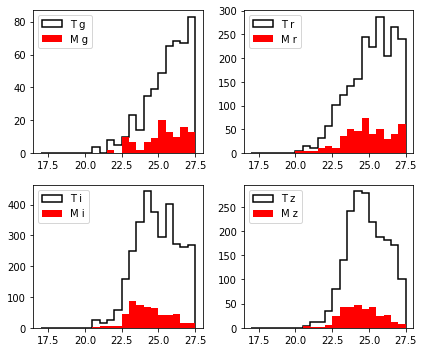

In [20]:
bandpasses = ('g', 'r', 'i', 'z')
bins=np.arange(17, 28, 0.5)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.mag, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T {band}')

    ax.hist(subtab[subtab.matched].mag, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M {band}')
    ax.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('matched_lcs.png')
#plt.clf()

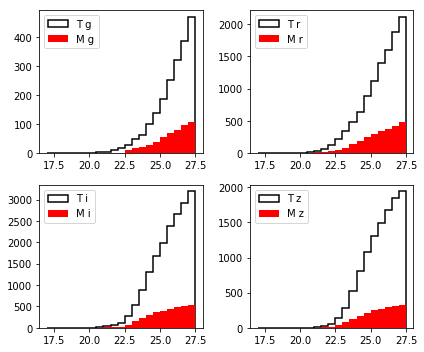

In [21]:
bandpasses = ('g', 'r', 'i', 'z')
bins=np.arange(17, 28, 0.5)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.mag, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T {band}', cumulative=True)

    ax.hist(subtab[subtab.matched].mag, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M {band}', cumulative=True)
    ax.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('matched_lcs.png')
#plt.clf()

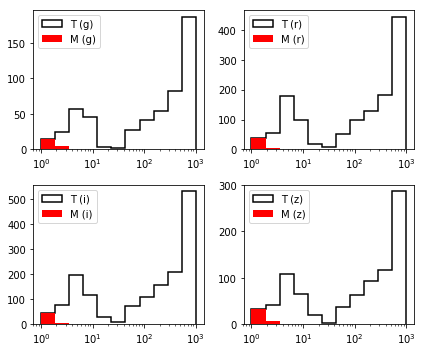

In [22]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.logspace(0, 3, num=12)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.match_ang_dist, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].match_ang_dist, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='upper left')
    ax.set_xscale('log')
plt.tight_layout()

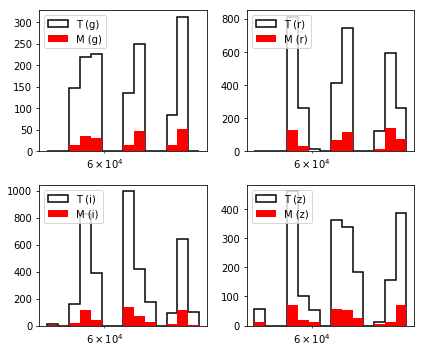

In [23]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.linspace(59580, 60700, num=15)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.mjd, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].mjd, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='upper left')
    ax.set_xscale('log')
plt.tight_layout()

In [24]:
matched_lcs.columns

Index(['mjd', 'filter', 'visitn', 'observable', 'observed', 'flux', 'fluxErr',
       'mag', 'magErr', 'snid_in', 'visit_used', 'matched', 'match_ang_dist',
       'dia_row', 'dia_id'],
      dtype='object')

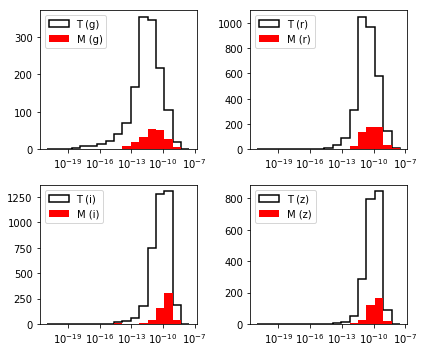

In [25]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.logspace(-21, -7.5, num=18)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.flux, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].flux, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='upper left')
    ax.set_xscale('log')
plt.tight_layout()

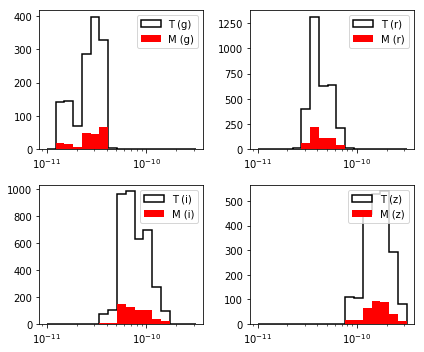

In [26]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.logspace(-11, -9.5, num=18)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.fluxErr, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].fluxErr, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='best')
    ax.set_xscale('log')
plt.tight_layout()

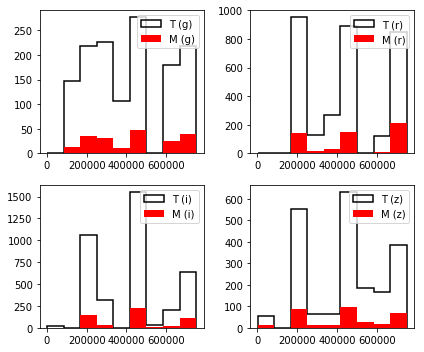

In [27]:
bandpasses = ('g', 'r', 'i', 'z')
bins = np.linspace(1500, 750000, num=10)
fig, axes = plt.subplots(figsize=(6,5), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab.visitn, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T ({band})')

    ax.hist(subtab[subtab.matched].visitn, histtype='stepfilled', lw=1.5, 
            bins=bins, color='red', label=f'M ({band})')
    ax.legend(loc='best')
    ax.set_xscale('linear')
plt.tight_layout()

In [28]:
matched_lcs.describe()

,mjd,visitn,flux,fluxErr,mag,magErr,match_ang_dist,dia_row,dia_id
count,10508.000000,10508.000000,1.050800e+04,1.050800e+04,10508.000000,10508.000000,10508.000000,10508.000000,1.050800e+04
mean,60197.876687,428274.050438,1.861305e-10,7.975249e-11,26.274926,1.659476,969.297609,35732.524743,2.874099e+16
std,285.805450,186359.335872,4.799253e-10,5.497606e-11,2.772788,1.984169,883.033533,28063.864067,1.250636e+16
min,59589.200927,6826.000000,6.638158e-21,1.441364e-11,19.855938,0.007867,0.012540,0.000000,4.580965e+14
25%,59887.190461,227924.000000,8.938471e-12,3.788820e-11,24.363451,0.389594,10.814826,11085.250000,1.529572e+16
50%,60201.259722,433996.000000,4.525452e-11,5.954960e-11,25.860845,1.026405,812.511146,29976.000000,2.912498e+16
75%,60531.374627,638919.000000,1.797296e-10,1.035304e-10,27.621842,2.273626,1697.598901,56305.750000,4.287714e+16
max,60661.174745,731790.000000,1.141892e-08,2.775778e-10,50.444881,24.221286,4747.711882,101877.000000,4.910960e+16


In [29]:
rows = []
for ivisit, subset in matched_lcs.groupby('visitn'):
    #print(str(ivisit).zfill(6), np.sum(subset.matched), str(len(subset)).zfill(2), f'{np.sum(subset.matched)/len(subset):.3}')
    rows.append([ivisit, np.sum(subset.matched), len(subset), np.sum(subset.matched)/len(subset), subset['filter'].values[0]])
summ = pd.DataFrame(data=rows, columns=['visitn', 'n_matches', 'total', 'fraction', 'bandpass'])

In [30]:
len(summ)

288

In [31]:
for band, subtab in summ.groupby('bandpass'):
    print(f'Bandpass {band} \n', subtab.describe(), '\n\n')

Bandpass g 
               visitn  n_matches      total   fraction
count      37.000000  37.000000  37.000000  37.000000
mean   403235.891892   5.486486  37.135135   0.153992
std    203319.268987   4.011245  19.167626   0.163329
min    159479.000000   0.000000   1.000000   0.000000
25%    193823.000000   2.000000  25.000000   0.090909
50%    400390.000000   5.000000  39.000000   0.144928
75%    637849.000000   8.000000  50.000000   0.166667
max    697958.000000  13.000000  69.000000   1.000000 


Bandpass i 
               visitn  n_matches      total   fraction
count      95.000000  95.000000  95.000000  95.000000
mean   441366.421053   5.842105  40.242105   0.159442
std    188060.032421   3.650461  22.339125   0.136406
min      6826.000000   0.000000   4.000000   0.000000
25%    250185.500000   3.000000  23.500000   0.096915
50%    433989.000000   6.000000  40.000000   0.133333
75%    654465.500000   9.000000  56.000000   0.200000
max    731790.000000  13.000000  84.000000   1.000000

------

In [32]:
matched_diasrc.columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'dia_object_id',
       'base_DiaTransformedCentroid_x', 'slot_Centroid_x',
       'base_DiaTransformedCentroid_y', 'slot_Centroid_y', 'base_SdssShape_xx',
       ...
       'slot_PsfShape_moments_yy_diag', 'slot_PsfShape_moments_ratio_diag',
       'slot_Shape_psf_moments_ratio_qs', 'slot_Shape_psf_moments_xx_diag',
       'slot_Shape_psf_moments_yy_diag', 'slot_Shape_psf_moments_ratio_diag',
       'cxmatch', 'sn_row', 'match_ang_dist', 'sn_id'],
      dtype='object', length=115)

In [33]:
matched_diasrc.describe()

,id,coord_ra,coord_dec,parent,dia_object_id,base_DiaTransformedCentroid_x,slot_Centroid_x,base_DiaTransformedCentroid_y,slot_Centroid_y,base_SdssShape_xx,...,slot_PsfShape_moments_ratio_qs,slot_PsfShape_moments_xx_diag,slot_PsfShape_moments_yy_diag,slot_PsfShape_moments_ratio_diag,slot_Shape_psf_moments_ratio_qs,slot_Shape_psf_moments_xx_diag,slot_Shape_psf_moments_yy_diag,slot_Shape_psf_moments_ratio_diag,sn_row,match_ang_dist
count,1.727197e+07,1.727197e+07,1.727197e+07,17271966.0,1.727197e+07,1.727197e+07,1.727197e+07,1.727197e+07,1.727197e+07,1.034817e+07,...,1.727192e+07,1.727192e+07,1.727192e+07,1.727192e+07,1.727192e+07,1.727192e+07,1.727192e+07,1.727192e+07,1.727197e+07,1.727197e+07
mean,2.904649e+16,9.933197e-01,-5.423818e-01,0.0,2.040442e+16,2.039066e+03,2.039066e+03,1.989884e+03,1.989884e+03,1.063951e+02,...,9.970742e-01,7.709553e+00,7.369678e+00,1.047542e+00,9.970742e-01,7.709553e+00,7.369678e+00,1.047542e+00,2.235014e+01,4.325719e+02
std,1.312860e+16,1.004072e-02,2.156698e-03,0.0,2.255589e+12,1.172928e+03,1.172928e+03,1.156731e+03,1.156731e+03,5.106858e+03,...,4.803785e-02,3.042236e+00,2.917186e+00,6.309727e-02,4.803785e-02,3.042236e+00,2.917186e+00,6.309727e-02,1.764144e+01,2.900172e+02
min,4.580950e+14,9.758740e-01,-5.458256e-01,0.0,2.040254e+16,-4.997028e-01,-4.997028e-01,-4.998956e-01,-4.998956e-01,1.010927e-05,...,1.735708e-02,1.666667e-01,-3.106254e+02,-1.292034e+01,1.735708e-02,1.666667e-01,-3.106254e+02,-1.292034e+01,0.000000e+00,1.254046e-02
25%,1.529533e+16,9.840738e-01,-5.441365e-01,0.0,2.040268e+16,1.024845e+03,1.024845e+03,9.841972e+02,9.841972e+02,5.426672e-01,...,9.811409e-01,5.511863e+00,5.294596e+00,1.019693e+00,9.811409e-01,5.511863e+00,5.294596e+00,1.019693e+00,6.000000e+00,2.279163e+02
50%,2.959092e+16,9.925290e-01,-5.426464e-01,0.0,2.040295e+16,2.041084e+03,2.041084e+03,1.985855e+03,1.985855e+03,7.381622e+00,...,1.000415e+00,7.153632e+00,6.838700e+00,1.032921e+00,1.000415e+00,7.153632e+00,6.838700e+00,1.032921e+00,2.100000e+01,3.723838e+02
75%,4.352339e+16,1.002073e+00,-5.406726e-01,0.0,2.040749e+16,3.054339e+03,3.054339e+03,2.991718e+03,2.991718e+03,1.348687e+01,...,1.020281e+00,8.725614e+00,8.349802e+00,1.054493e+00,1.020281e+00,8.725614e+00,8.349802e+00,1.054493e+00,3.400000e+01,5.745655e+02
max,4.910960e+16,1.014723e+00,-5.380219e-01,0.0,2.040776e+16,4.071500e+03,4.071500e+03,3.999500e+03,3.999500e+03,7.904485e+06,...,1.952653e+01,9.320594e+02,9.202869e+01,1.182135e+02,1.952653e+01,9.320594e+02,9.202869e+01,1.182135e+02,8.300000e+01,3.300657e+03


### Storing datasets

* Storing the datasets as three tables:
    * Reals table (`diaSrc` instances that have been matched to a SN lightcurve epoch)
    * Bogus table (`diaSrc` instances that have **NOT** been matched to a SN lightcurve epoch)
    * Matched LCs table (truth lightcurve table with the matching result information attached.)

In [34]:
reals = matched_diasrc.loc[matched_diasrc['cxmatch']]
bogus = matched_diasrc.loc[~matched_diasrc['cxmatch']]

In [35]:
len(reals)

1660

In [36]:
len(bogus)

17270306

The following quantity reflects the actual portion of the truth lightcurve instances that were possible to be used because of image processing failing

In [37]:
np.sum(lcs['visit_used'])/len(lcs)

0.38697797746188406

In [38]:
len(matched_lcs)/len(lcs)

0.38697797746188406

In [39]:
(len(reals) + len(bogus))/len(diasrc_tab)

0.9740888582615017

In [40]:
reals.to_csv(f'{SCRATCH}/results/forced_reals_table.csv')
bogus.to_csv(f'{SCRATCH}/results/forced_bogus_table.csv')
matched_lcs.to_csv(f'{SCRATCH}/results/forced_matched_lcs_visit_by_visit.csv')

-----------

_Moved to the visit_check.ipynb Notebook_
### Analyzing visits used